In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
complaints = pd.read_csv("complaints_25Nov21.csv")

In [2]:
complaints.head(100)

NameError: name 'complaints' is not defined

In [212]:
complaints.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [213]:
complaints.Company.value_counts().sort_values(ascending=False).head(50)

BANK OF AMERICA, NATIONAL ASSOCIATION    65440
WELLS FARGO & COMPANY                    53111
JPMORGAN CHASE & CO.                     42170
CITIBANK, N.A.                           34341
U.S. BANCORP                             12198
Name: Company, dtype: int64

In [214]:
complaints['Consumer disputed?'].value_counts()

No     162357
Yes     44903
Name: Consumer disputed?, dtype: int64

In [215]:
complaints['Consumer disputed?'].value_counts().sum()

207260

In [216]:
complaints['Consumer disputed?'].isna().sum()

0

In [217]:
complaints['Consumer disputed?'].fillna('No', inplace=True)
complaints['Consumer disputed?'] = complaints['Consumer disputed?'].astype('category')

In [218]:
complaints['Consumer disputed?'].value_counts()

No     162357
Yes     44903
Name: Consumer disputed?, dtype: int64

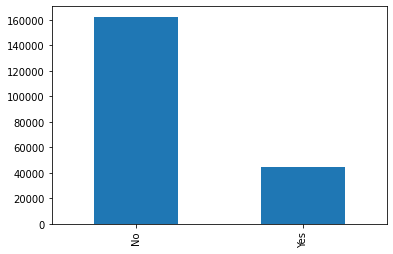

In [219]:
complaints['Consumer disputed?'].value_counts().plot(kind='bar')

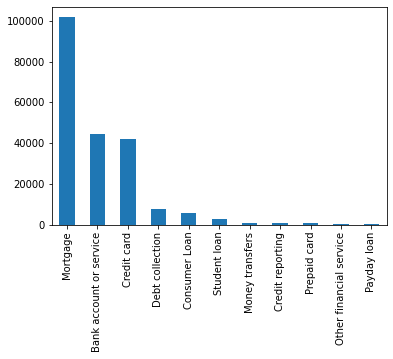

In [220]:
complaints['Product'].value_counts().plot(kind='bar')

In [221]:
complaints['Product'].value_counts()

Mortgage                   101680
Bank account or service     44594
Credit card                 42191
Debt collection              7861
Consumer Loan                5508
Student loan                 2866
Money transfers               869
Credit reporting              741
Prepaid card                  635
Other financial service       232
Payday loan                    83
Name: Product, dtype: int64

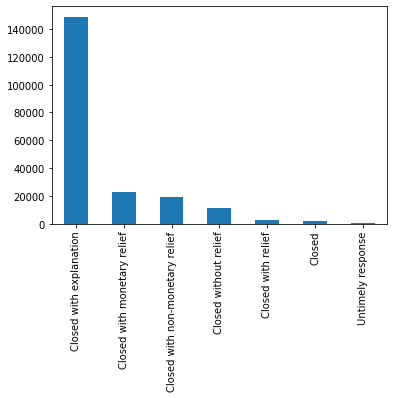

In [222]:
complaints['Company response to consumer'].value_counts().plot(kind='bar')

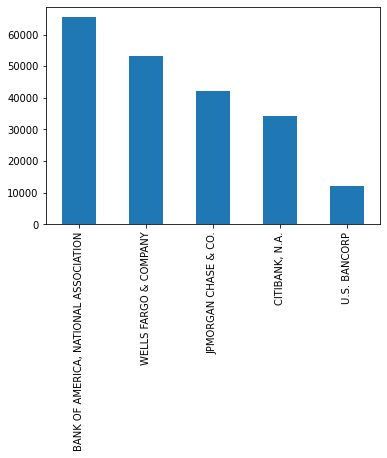

In [223]:
complaints['Company'].value_counts().plot(kind='bar')

In [224]:
#percentage
complaints['Consumer disputed?'].value_counts() / (complaints['Consumer disputed?'].value_counts().sum())

No     0.783349
Yes    0.216651
Name: Consumer disputed?, dtype: float64

In [225]:
X = complaints[[ 'Product', 'Sub-product', 'Issue', 'Sub-issue',
        'Company public response', 'Company',
       'State',  'Tags', 'Consumer consent provided?',
       'Submitted via',  'Company response to consumer',
       'Timely response?']]

In [226]:
#Checking for missing values in the edited dataset
print(len(X))
print(len(X.dropna()))

207260
435


In [227]:
X = pd.get_dummies(X)

In [228]:
y = complaints['Consumer disputed?']

In [229]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(complaints['Consumer disputed?'])
print(le.classes_)
print(le.inverse_transform(list(set(y))))
labels = dict(zip(list(set(y)), le.inverse_transform(list(set(y)))))
print("\nLabel mapping is:", labels)

['No' 'Yes']
['No' 'Yes']

Label mapping is: {0: 'No', 1: 'Yes'}


In [230]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [231]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(165808, 305)
(165808,)
(41452, 305)
(41452,)


In [232]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [233]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(207260, 305)
(71818, 305)
(41452, 305)


Fitting the model using XGBoost


In [234]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(use_label_encoder=False, objective= 'binary:logistic')
model_xgb.fit(X_train, y_train)

XGBClassifier(use_label_encoder=False)

In [235]:
pred = model_xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.84      0.55      0.66     32458
           1       0.27      0.61      0.38      8994

    accuracy                           0.56     41452
   macro avg       0.55      0.58      0.52     41452
weighted avg       0.71      0.56      0.60     41452



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


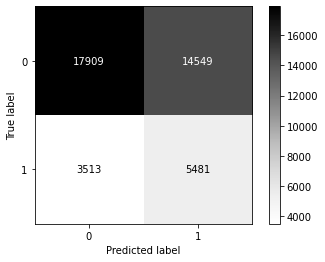

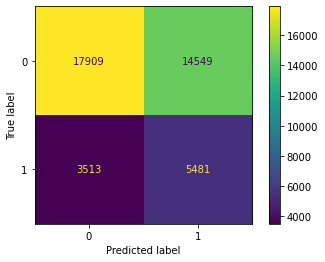

In [236]:
print(classification_report(y_true = y_test, y_pred = pred))
plot_confusion_matrix(model_xgb, X = X_test, y_true = y_test, cmap='Greys');

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [237]:
threshold = 0.50

In [270]:
pred_prob = model_xgb.predict_proba(X_test)

pred_prob = pred_prob[:,1]

pred = (pred_prob>threshold).astype(int)

cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
 
print('Test accuracy = ', accuracy_score(y_test, pred))

Confusion Matrix : 
 [[   51 32407]
 [    1  8993]]
Test accuracy =  0.2181800636881212


In [239]:
print(classification_report(y_true = y_test, y_pred = pred))

              precision    recall  f1-score   support

           0       0.84      0.55      0.66     32458
           1       0.27      0.61      0.38      8994

    accuracy                           0.56     41452
   macro avg       0.55      0.58      0.52     41452
weighted avg       0.71      0.56      0.60     41452



In [240]:
pred_prob

array([0.56518596, 0.5631369 , 0.57147527, ..., 0.4475068 , 0.4983394 ,
       0.27067378], dtype=float32)

AUC and ROC Calculation

In [241]:
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

0.6139613971360234

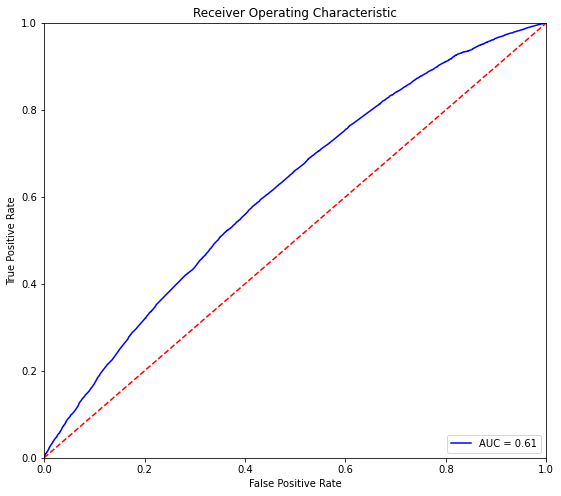

In [242]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [243]:
pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds}).sort_values(by = ['Threshold']).reset_index(drop=True)

,TPR,FPR,Threshold
0,1.000000,1.000000,0.092425
1,1.000000,0.999938,0.123244
2,1.000000,0.999846,0.128234
3,1.000000,0.999815,0.129374
4,1.000000,0.999754,0.134213
...,...,...,...
5173,0.000778,0.000092,0.695674
5174,0.000778,0.000062,0.702127
5175,0.000111,0.000062,0.704008
5176,0.000111,0.000031,0.709054


Running the model on XGBoost with different threshold

In [253]:
threshold = 0.40

In [271]:
pred_prob = model_xgb.predict_proba(X_test)

pred_prob = pred_prob[:,1]

pred = (pred_prob>threshold).astype(int)

cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
 
print('Test accuracy = ', accuracy_score(y_test, pred))

Confusion Matrix : 
 [[   51 32407]
 [    1  8993]]
Test accuracy =  0.2181800636881212


In [255]:
print(classification_report(y_true = y_test, y_pred = pred))

              precision    recall  f1-score   support

           0       0.90      0.18      0.31     32458
           1       0.24      0.92      0.38      8994

    accuracy                           0.34     41452
   macro avg       0.57      0.55      0.34     41452
weighted avg       0.75      0.34      0.32     41452



In [256]:
pred_prob

array([0.56518596, 0.5631369 , 0.57147527, ..., 0.4475068 , 0.4983394 ,
       0.27067378], dtype=float32)

AUC and ROC Calculation

In [257]:
# AUC calculation
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

0.6139613971360234

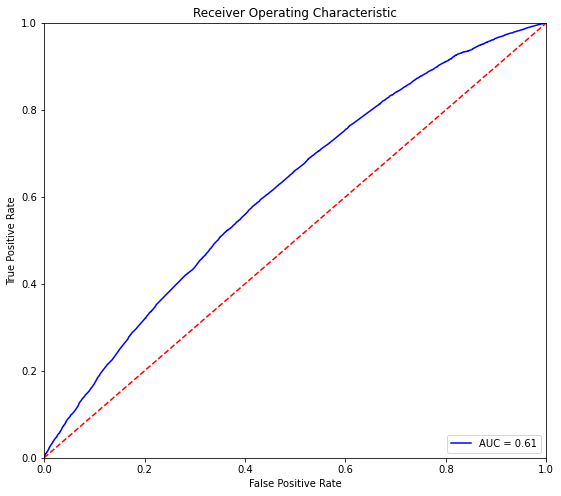

In [258]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Fitting the model on XGBoost again

In [259]:
threshold = 0.30

In [260]:
pred_prob = model_xgb.predict_proba(X_test)

pred_prob = pred_prob[:,1]

pred = (pred_prob>threshold).astype(int)

cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
 
print('Test accuracy = ', accuracy_score(y_test, pred))

Confusion Matrix : 
 [[ 2029 30429]
 [  184  8810]]
Test accuracy =  0.2614831612467432


In [261]:
print(classification_report(y_true = y_test, y_pred = pred))

              precision    recall  f1-score   support

           0       0.92      0.06      0.12     32458
           1       0.22      0.98      0.37      8994

    accuracy                           0.26     41452
   macro avg       0.57      0.52      0.24     41452
weighted avg       0.77      0.26      0.17     41452



AUC and ROC Calculation

In [262]:
# AUC calculation
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

0.6139613971360234

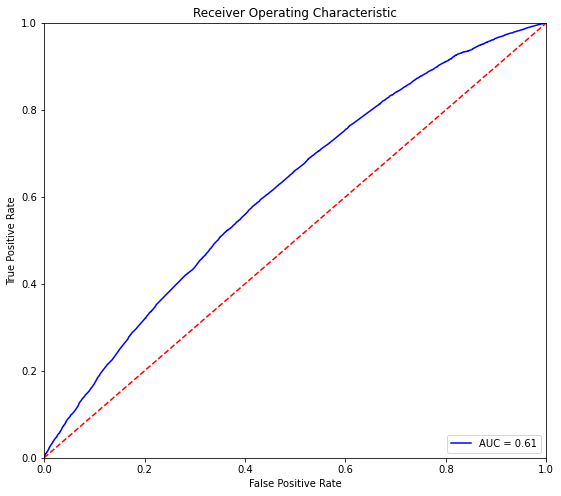

In [263]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [264]:
threshold = 0.2

In [265]:
pred_prob = model_xgb.predict_proba(X_test)

pred_prob = pred_prob[:,1]

pred = (pred_prob>threshold).astype(int)

cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
 
print('Test accuracy = ', accuracy_score(y_test, pred))

Confusion Matrix : 
 [[   51 32407]
 [    1  8993]]
Test accuracy =  0.2181800636881212


In [266]:
print(classification_report(y_true = y_test, y_pred = pred))

              precision    recall  f1-score   support

           0       0.98      0.00      0.00     32458
           1       0.22      1.00      0.36      8994

    accuracy                           0.22     41452
   macro avg       0.60      0.50      0.18     41452
weighted avg       0.82      0.22      0.08     41452



In [267]:
# AUC calculation
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

0.6139613971360234

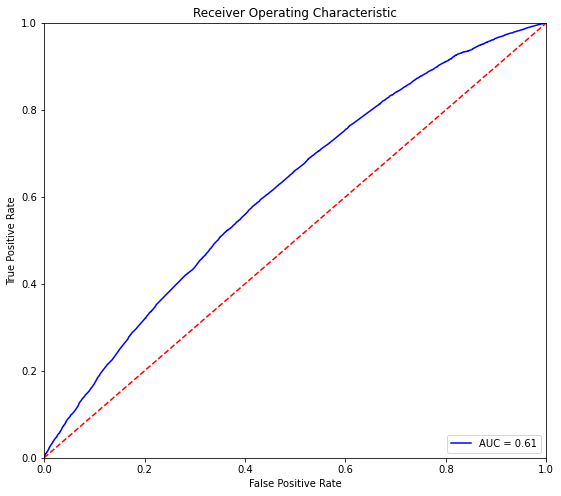

In [268]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()